\setcounter{secnumdepth}{0}

# Assignment 2.1 - Simulating dynamical systems in Jax

    Name: Clara Periago
    Student #: s1067476

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.random import PRNGKey

# Exercise 1: Analytical solution of linear systems
For linear systems $\dot{x} = A x$, we can often analytically compute the solution.

A) Using separation of variables, write down an analytical solution of the ordinary differential equation
$$\dfrac{dx}{dt} = \lambda x.$$

B) Using this solution, plot the dynamics of the system over time for different initial conditions and different values of $\lambda$.

$$
\begin{align*}
\frac{1}{x}dx &= \lambda dt && \text{separate variables} \\
\int \frac{1}{x}dx &= \int \lambda dt && \text{integrate} \\
\ln x &= \lambda t + C \\
e^{\ln x} &= e^{\lambda t} e^{C} && \text{exponentiate and simplify} \\
x(t) &= x_0 e^{\lambda t} && \text{with } x_0 = e^{C} \\
\end{align*}
$$

ERROR:2025-09-10 15:15:29,570:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CU

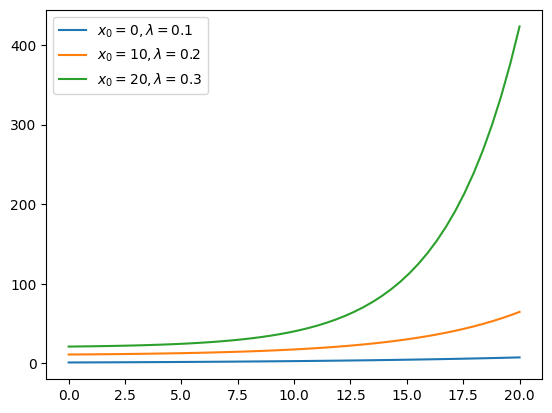

In [2]:
t = jnp.linspace(0, 20, 50)

x0s = [0, 10, 20]
lambdas = [0.1, 0.2, 0.3]

for x0, _lambda in zip(x0s, lambdas):
    fx = lambda t: x0 + jnp.exp(_lambda * t)
    plt.plot(t, fx(t), label=fr"$x_0={x0}, \lambda={_lambda}$")

plt.legend();

#  Exercise 2: Numerical approximation for the harmonic oscillator

Not all systems can be solved analytically. For these systems, we can instead use numerical techniques to solve the integration in order to get the system's trajectory. You may implement the simulation using a for-loop or with jax.lax.scan() (which we advice).

## 2.1:
Create a numerical approximation of the simple harmonic oscillator (i.e., the harmonic oscillator with a damping coefficient of zero) using the Euler method: $$  x_{n+1}=x_{n}+\Delta_t f(t_{n},x_{n}) $$

Solve the system forward in the range $t \in [0, 50]$ with a step size of $\Delta_t = 0.001$.

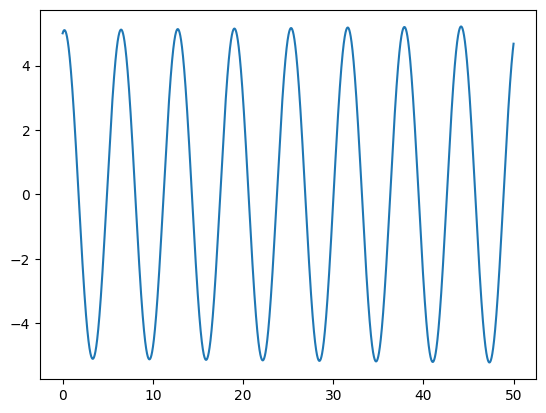

In [3]:
dt = 0.001
t = jnp.arange(0, 50, dt)

def harmonic_oscillator(k=1.): # oscillator written as matrix
    def _wrap(t, c):
        x, v = c
        return jnp.array([v, -k * x])
    return _wrap

def euler(fn, dt=0.001):
    @jax.jit
    def step(x, t):
        xn1 = x + dt * fn(t, x)
        return xn1
    
    return step

# helper wrapper that takes a step solver, initial conditions and time domain
def simulate(solver, c0, t):
    def iterate(c, t):
        xn1 = solver(c, t)
        return xn1, xn1[0]
    
    _, xs = jax.lax.scan(iterate, c0, t)
    return xs

x0 = 5.
v0 = 1.

oscillator = harmonic_oscillator(k=1.)
# step function via euler
euler_solver = euler(oscillator, dt)
xs = simulate(euler_solver, jnp.array([x0, v0]), t)

plt.plot(t, xs)

## 2.2:
Visualize different approximations as a function of the step size. You may only make use of the packages listed above. 

Comment on what you see, and explain your observations.

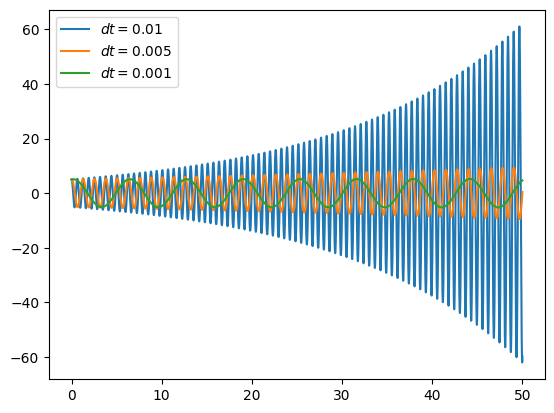

In [4]:
dts = [0.001, 0.005, 0.01]

for dt in sorted(dts, reverse=True): # sorted since higher dts produce more noisy output
    xs = simulate(euler(oscillator, dt=dt), jnp.array([x0, v0]), t)

    plt.plot(t, xs, label=rf"${dt=}$")

plt.legend()

As the step size increases, we get different values for the amplitude and frequency of the resulting wave. A lower value of $dt$ means each time step contributes less to the overall movement.

For high values of dt (0.01), the amplitude increases over time. I am not sure why this happens, since nothing else is changed. Numerical error/instability?

## 2.3

Write a RK4 solver and use it to simulate the simple harmonic oscillator. Using different step sizes, what do you observe? Compare your solution with Euler’s method. The RK4 solvers works as follows:

$$x_{n+1} = x_n + \frac{\Delta_t}{6}(k_1 + 2k_2 + 2k_3 + k_4)$$
$$t_{n+1} = t_n + \Delta_t$$
with
$$k_1 = f(t_n, x_n)$$
$$k_2 = f(t_n + \frac{\Delta_t}{2}, x_n + \Delta_t\frac{k_1}{2})$$
$$k_3 = f(t_n + \frac{\Delta_t}{2}, x_n + \Delta_t\frac{k_2}{2})$$
$$k_4 = f(t_n + \Delta_t, x_n + \Delta_t k_3)$$

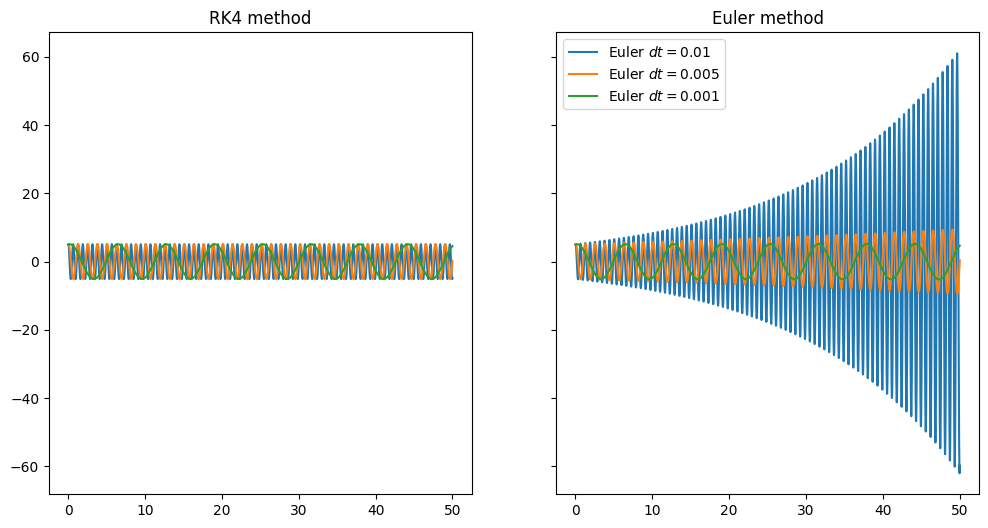

In [5]:
def rk4(f, dt):
    @jax.jit
    def step(x, t):
        k1 = f(t, x)
        k2 = f(t + .5 * dt, x + .5 * dt * k1)
        k3 = f(t + .5 * dt, x + .5 * dt * k2)
        k4 = f(t + dt, x + dt * k3)

        xn1 = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return xn1

    return step

fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# sorted since higher dts produce more noisy output
for dt in sorted(dts, reverse=True):
    iterate_rk4 = rk4(oscillator, dt)
    iterate_euler = euler(oscillator, dt)

    xs_rk4 = simulate(iterate_rk4, jnp.array([x0, v0]), t)
    xs_euler = simulate(iterate_euler, jnp.array([x0, v0]), t)

    axs[0].plot(t, xs_rk4, label=rf"RK4 ${dt=}$")
    axs[1].plot(t, xs_euler, label=rf"Euler ${dt=}$")

axs[0].set_title("RK4 method")
axs[1].set_title("Euler method")
plt.legend();


Indeed the RK4 solver is much more numerically stable than the Euler method. We do not see the issue with the amplitude (incorrectly) growing as the system evolves.